In [106]:
import pandas as pd
import numpy as np

df = pd.read_csv('BusinessMasterFile.csv')
df.head()

,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,...,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,RULEYEAR,LEVEL4,ACT1,ACT2,ACT3
0,19818,PALMER SECOND BAPTIST CHURCH,NaN,1050 THORNDIKE ST,PALMER,MA,01069-1507,3125,3,9,...,NaN,NaN,NaN,NaN,3514,1955,NaN,100,0.0,0.0
1,29215,ST GEORGE CATHEDRAL,NaN,523 E BROADWAY,SOUTH BOSTON,MA,02127-4415,2365,3,9,...,NaN,NaN,NaN,NaN,NaN,1972,NaN,100,0.0,0.0
2,587764,IGLESIA BETHESDA INC,NaN,157 ANDOVER ST,LOWELL,MA,01852-2348,0,3,3,...,NaN,NaN,NaN,X21,NaN,2004,X,0,NaN,NaN
3,635913,MINISTERIO APOSTOLICO JESUCRISTO ES EL SENOR INC,NaN,454 ESSEX ST,LAWRENCE,MA,01840-1242,0,3,3,...,NaN,NaN,NaN,X21,NaN,2004,X,0,NaN,NaN
4,765634,MERCY CHAPEL INTERNATIONAL,NaN,75 MORTON VILLAGE DR APT 408,MATTAPAN,MA,02126-2433,0,3,3,...,NaN,NaN,NaN,X20,NaN,2004,X,0,NaN,NaN


In [107]:
import missingno as msno
import matplotlib.pyplot as plt
plt.style.use('ggplot')

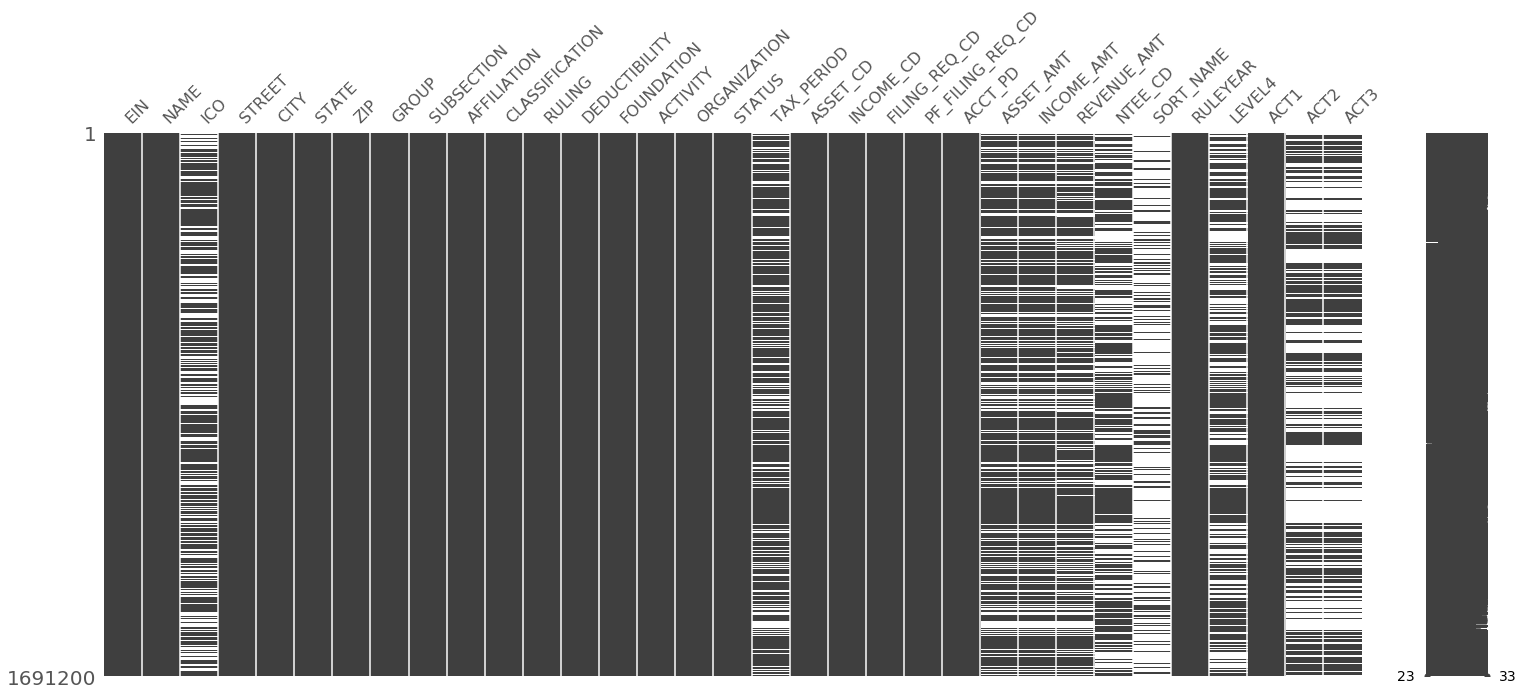

In [108]:
msno.matrix(df)

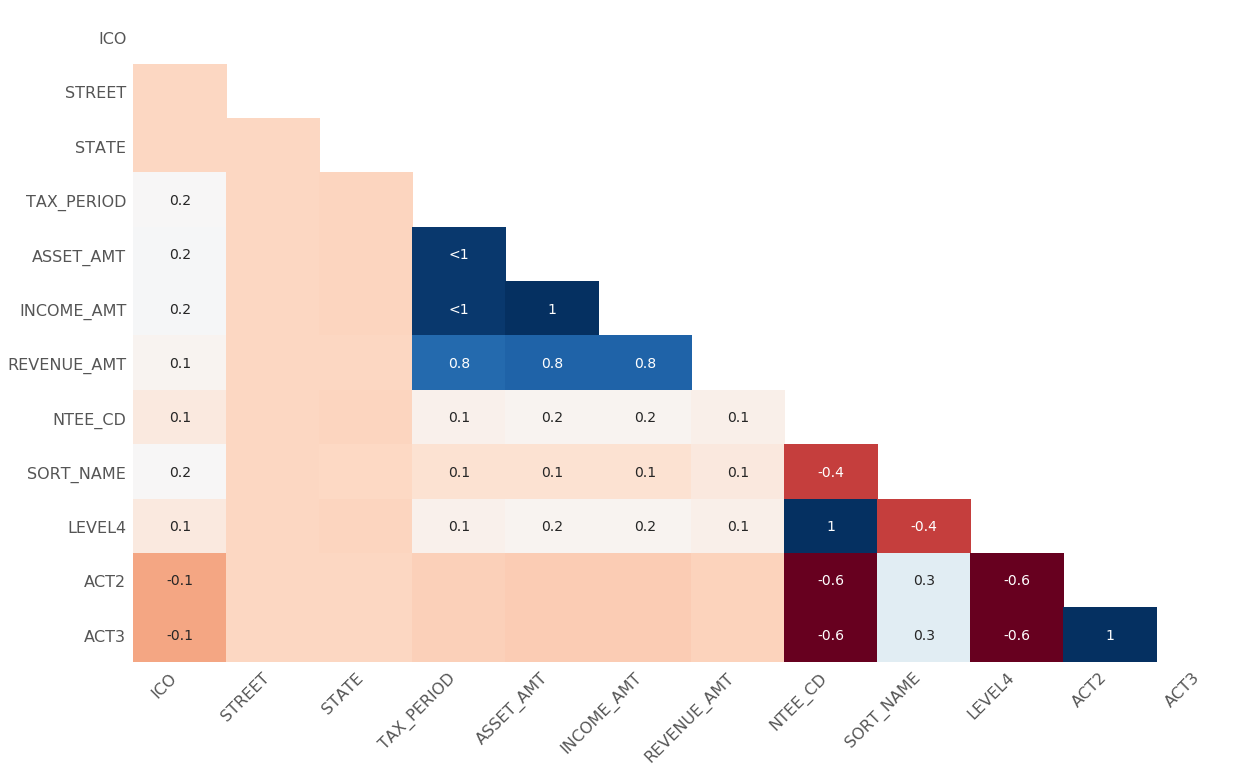

In [109]:
msno.heatmap(df)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1691200 entries, 0 to 1691199
Data columns (total 33 columns):
EIN                 int64
NAME                object
ICO                 object
STREET              object
CITY                object
STATE               object
ZIP                 object
GROUP               int64
SUBSECTION          int64
AFFILIATION         int64
CLASSIFICATION      int64
RULING              int64
DEDUCTIBILITY       int64
FOUNDATION          int64
ACTIVITY            int64
ORGANIZATION        int64
STATUS              int64
TAX_PERIOD          float64
ASSET_CD            int64
INCOME_CD           int64
FILING_REQ_CD       int64
PF_FILING_REQ_CD    int64
ACCT_PD             int64
ASSET_AMT           float64
INCOME_AMT          float64
REVENUE_AMT         float64
NTEE_CD             object
SORT_NAME           object
RULEYEAR            int64
LEVEL4              object
ACT1                int64
ACT2                float64
ACT3                float64
dtypes: 

In [111]:
print(df.REVENUE_AMT.value_counts()[:5])
df.REVENUE_AMT.isna().value_counts()

0.0        688791
1000.0        296
500.0         221
5000.0        215
100.0         214
1.0           204
10000.0       185
2000.0        163
3000.0        133
200.0         129
1500.0        122
2500.0        116
2.0           105
6000.0        103
300.0          99
5.0            98
Name: REVENUE_AMT, dtype: int64


False    1212088
True      479112
Name: REVENUE_AMT, dtype: int64

In [112]:
print(df.ASSET_AMT.value_counts()[:5])
print(df.ASSET_AMT.isna().sum())
print(df.ASSET_CD.value_counts()[:5])
print(df.ASSET_CD.isna().sum())

0.0        677902
1.0         15623
100.0         285
1000.0        217
500.0         191
200.0         120
2000.0        108
5000.0        103
10.0          101
50.0           90
300.0          83
1500.0         81
150.0          73
10000.0        69
25.0           69
5.0            67
Name: ASSET_AMT, dtype: int64
368826
0    1032113
4     169004
3     123873
6     101784
1      80491
Name: ASSET_CD, dtype: int64
0


I am trying to decide whether or not to drop ASSEST_CD/ASSET_AMT and INCOME_AMT/INCOME_CD.

ASSET_AMT is continious data, rather than the coded data in ASSET_CD, so I will keep the AMTs reported over the prebinned. I can alter it myself if need be. Also there seems to be some discrepancy in values from the coded and the reported, which makes my decision. 

Tasks:
- Combine `city`, `street`, `state` into lat and longs. Drop `city`, `street`, `state`. This is the location of the headquarters and doesn't mean that the 501c has operations in that state. [https://github.com/geopy/geopy]
- Change datetime data into correct formats. `TAX_PERIOD`, `RULING_DATE`
- Make things categorical
- Investigate any connection between SORT_NAME and GROUP EXEMPTION NUM and AFFILCATION CODE [Connection?](#task1)
- Check the Ruling year after 1995 and see if any NTEE exisits.


<a id="task1"></a>

Sort Name Line is another name under which the organization does business.  Also used for trade names, chapter names, or local numbers for subordinate organizations of group rulings

Central - This code is used if the organization is a central type organization (no group exemption) of a National, Regional or Geographic grouping of organizations. 2 Intermediate - This code is used if the organization is an intermediate organization (no group exemption) of a National, Regional or Geographic grouping of organizations (such as a state headquarters of a national organization). 3 Independent - This code is used if the organization is an independent organization or an independent auxiliary 
(i.e., not affiliated with a National, Regional, or Geographic grouping of organizations). 6 Central - This code is used if the organization is a parent (group ruling) and is not a church or 501(c)(1) organization. 7 Intermediate - This code is used if the organization is a group exemption intermediate organization of a National, Regional or Geographic grouping of organizations. 8 Central - This code is used if the organization is a parent (group ruling) and is a church or 501(c)(1) organization. 9 Subordinate - This code is used if the organization is a subordinate in a group ruling

In [113]:
df.drop(['ICO', 
         'RULING', 
         'ACT2', 
         'ACT3', 
         'ASSET_CD', 
         'INCOME_CD', 
         'LEVEL4', 
         'TAX_PERIOD'], axis=1, inplace=True)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1691200 entries, 0 to 1691199
Data columns (total 25 columns):
EIN                 int64
NAME                object
STREET              object
CITY                object
STATE               object
ZIP                 object
GROUP               int64
SUBSECTION          int64
AFFILIATION         int64
CLASSIFICATION      int64
DEDUCTIBILITY       int64
FOUNDATION          int64
ACTIVITY            int64
ORGANIZATION        int64
STATUS              int64
FILING_REQ_CD       int64
PF_FILING_REQ_CD    int64
ACCT_PD             int64
ASSET_AMT           float64
INCOME_AMT          float64
REVENUE_AMT         float64
NTEE_CD             object
SORT_NAME           object
RULEYEAR            int64
ACT1                int64
dtypes: float64(3), int64(15), object(7)
memory usage: 322.6+ MB


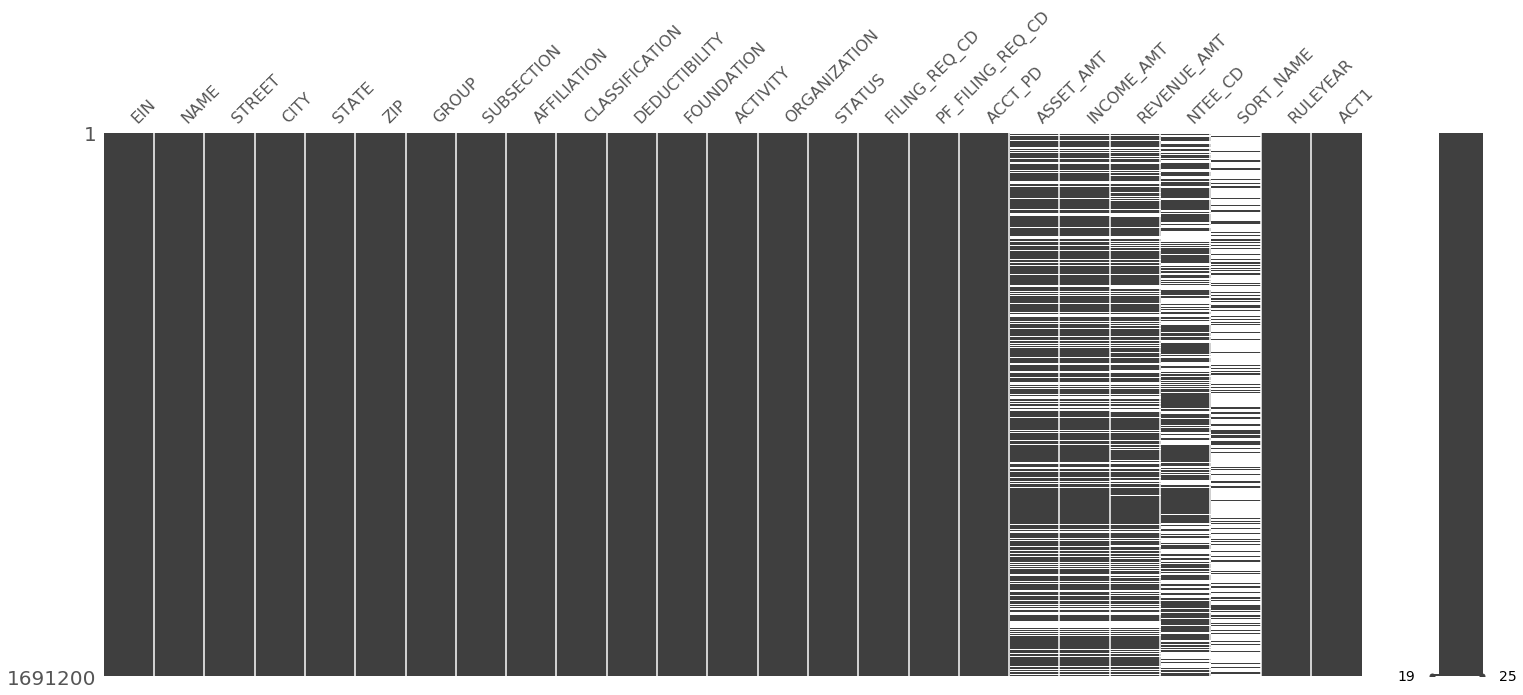

In [115]:
msno.matrix(df)

There is a clear pattern of missing values from `ASSET_AMT`,`INCOME_AMT`, and `REVENUE_AMT`. I will drop values from one column, extending down the rows and then will recheck the patterns.

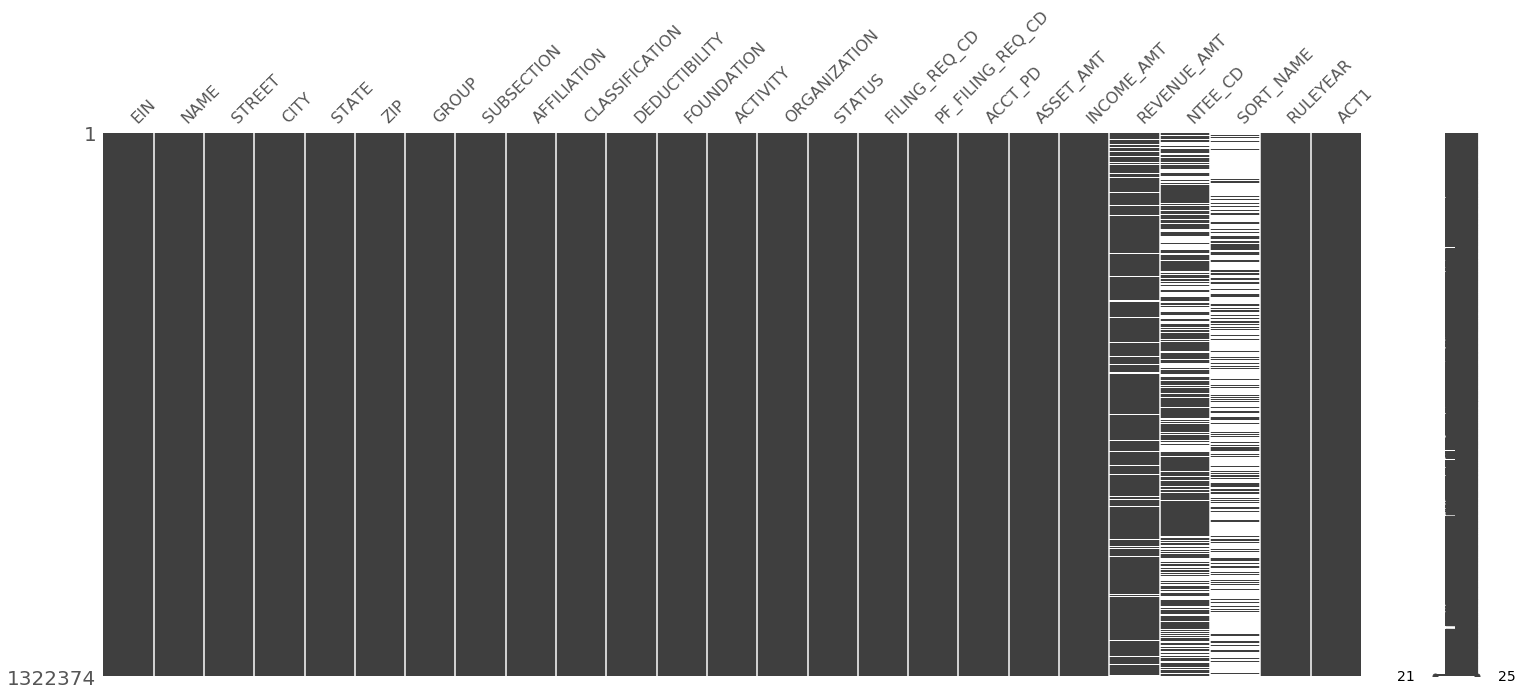

In [116]:
df = df.dropna(subset=['ASSET_AMT'])
msno.matrix(df)

~370,000 entries were removed. 

In [117]:
df.isna().sum()

EIN                      0
NAME                     0
STREET                   2
CITY                     0
STATE                 1062
ZIP                      0
GROUP                    0
SUBSECTION               0
AFFILIATION              0
CLASSIFICATION           0
DEDUCTIBILITY            0
FOUNDATION               0
ACTIVITY                 0
ORGANIZATION             0
STATUS                   0
FILING_REQ_CD            0
PF_FILING_REQ_CD         0
ACCT_PD                  0
ASSET_AMT                0
INCOME_AMT               0
REVENUE_AMT         110286
NTEE_CD             451552
SORT_NAME           965875
RULEYEAR                 0
ACT1                     0
dtype: int64

The last 100K from `REVENUE_AMT` will be dropped as well. I will combine the `SORT_NAME` column with the `NAME` column since they both come from the same field, just a different line. `NTEE_CD` will be addressed seperately as well.

In [118]:
df = df.dropna(subset=['REVENUE_AMT'])

In [119]:
df.isna().sum()

EIN                      0
NAME                     0
STREET                   2
CITY                     0
STATE                  940
ZIP                      0
GROUP                    0
SUBSECTION               0
AFFILIATION              0
CLASSIFICATION           0
DEDUCTIBILITY            0
FOUNDATION               0
ACTIVITY                 0
ORGANIZATION             0
STATUS                   0
FILING_REQ_CD            0
PF_FILING_REQ_CD         0
ACCT_PD                  0
ASSET_AMT                0
INCOME_AMT               0
REVENUE_AMT              0
NTEE_CD             415581
SORT_NAME           868547
RULEYEAR                 0
ACT1                     0
dtype: int64

In [120]:
df.SORT_NAME = df.SORT_NAME.fillna(value = '') #Replaces np.NaN values with something else, string + np.NaN = np.NaN
df['NAME_FULL'] = df.NAME + ' ' + df.SORT_NAME #New column
df.drop(['NAME', 'SORT_NAME'], axis=1, inplace=True) #Getting rid of the old
df.head()

,EIN,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,DEDUCTIBILITY,...,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,RULEYEAR,ACT1,NAME_FULL
12,10002847,PO BOX 126,HULLS COVE,ME,04644-0126,0,3,3,1000,1,...,2,0,12,0.0,0.0,0.0,A80,2000,0,HULLS COVE NEIGHBORHOOD ASSOCIATION
13,10011694,30 SAMUEL PRESCOTT DR,STOW,MA,01775-1167,0,3,3,1000,1,...,2,0,12,0.0,0.0,0.0,S19,2015,995,MASSACHUSETTS MODERATORS ASSOCIATION
14,10015091,PO BOX 13,CEDAR KNOLLS,NJ,07927-0013,0,3,3,1000,1,...,1,0,12,62462.0,140685.0,140685.0,N64,2012,0,HANOVER SOCCER CLUB INC
15,10017496,PO BOX 534,YORK HARBOR,ME,03911-0534,0,3,3,2000,1,...,1,0,12,233819.0,180773.0,127013.0,NaN,1993,149,AGAMENTICUS YACHT CLUB OF YORK
16,10018555,81 COLLEGE AVE,ORONO,ME,04473-4210,287,7,9,1000,2,...,2,0,12,0.0,0.0,0.0,NaN,1941,360,ALPHA TAU OMEGA FRATERNITY BETA UPSILION MAINE...


In [121]:
df.isna().sum()

EIN                      0
STREET                   2
CITY                     0
STATE                  940
ZIP                      0
GROUP                    0
SUBSECTION               0
AFFILIATION              0
CLASSIFICATION           0
DEDUCTIBILITY            0
FOUNDATION               0
ACTIVITY                 0
ORGANIZATION             0
STATUS                   0
FILING_REQ_CD            0
PF_FILING_REQ_CD         0
ACCT_PD                  0
ASSET_AMT                0
INCOME_AMT               0
REVENUE_AMT              0
NTEE_CD             415581
RULEYEAR                 0
ACT1                     0
NAME_FULL                0
dtype: int64

My target is going to `ACTIVITY`/`NTEE_CD`. The values in `ACTIVITY` are 9 characters long, each set of three indicating what kind of the organization it is There are some that needed more than one set of three to define their organization, others only have one. Planning to use only the first activity code. Also I have to keep in mind, there are ones that could apply to different targets. As expected, the data itself is not that clean. Effort will be made to tidy it up.

The NTEE_CD code was introduced to replace the three digit code after **(CHECK if not 1994/1996)** tax year 1995. I will make my own mapping from the old system to the new system.  

I will run three models; a pre-1995 target, post-1995 target, and the entire dataset with a semi-converted target. The mapping that I create will is an area of potential error. This is a place of further improvement on future iterations of this project. 

In [122]:
df.loc[(df.NTEE_CD.notna()) & (df.ACTIVITY == 0)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604936 entries, 12 to 1691194
Data columns (total 24 columns):
EIN                 604936 non-null int64
STREET              604936 non-null object
CITY                604936 non-null object
STATE               604403 non-null object
ZIP                 604936 non-null object
GROUP               604936 non-null int64
SUBSECTION          604936 non-null int64
AFFILIATION         604936 non-null int64
CLASSIFICATION      604936 non-null int64
DEDUCTIBILITY       604936 non-null int64
FOUNDATION          604936 non-null int64
ACTIVITY            604936 non-null int64
ORGANIZATION        604936 non-null int64
STATUS              604936 non-null int64
FILING_REQ_CD       604936 non-null int64
PF_FILING_REQ_CD    604936 non-null int64
ACCT_PD             604936 non-null int64
ASSET_AMT           604936 non-null float64
INCOME_AMT          604936 non-null float64
REVENUE_AMT         604936 non-null float64
NTEE_CD             604936 non-null o

In [123]:
df.NTEE_CD.notna().sum()

796507

In [124]:
df.NTEE_CD.isna().sum()

415581

In [125]:
df.ACTIVITY.value_counts()[:10]

0            648115
59000000      12946
907908000     11636
59035000      11596
205000000     10981
36000000      10129
263264279      9497
200000000      9436
319000000      8836
59319000       8748
Name: ACTIVITY, dtype: int64

### MOVE ABOVE `NTEE_CD` CODING

There is something wrong with the above `.value_counts()`. The Activity Codes provided by the IRS have leading zeroes. Since there wasn't an attempt to control for it them when orginally reading the files, I want further to investigate if the `ACTIVITY` lines contain 9 characters. If they don't, I will adjust them accordingly.

In [161]:
temp = df.ACTIVITY

In [162]:
length = []
for x in temp:
    length.append(len(str(x)))
pd.Series(length).value_counts()

1    604936
9    389701
8    163953
7     10319
dtype: int64

As expected, adjustments are need. Make a small function that will adjust the `ACTIVITY` input to match the 9 character length expected.

In [206]:
def adj_len(num):
    string = str(num)
    
    if len(string) >= 7:
        
        if len(string) == 9:
            return int(string[0:3])
        if len(string) == 8:
            return int(string[0:2])
        if len(string) == 7:
            return int(string[0:1])
    else:
        return num
    

In [205]:
adj_len(123456789)

123456789

Tester set for a encoding that I will do.

In [178]:
small = df.loc[(df.NTEE_CD.isna()) & (df.ACTIVITY != 0)][:100]

In [227]:
def code_NTEE_V1(y):
    
    x = adj_len(y)
    
    list_a =list(range(60,120))
    list_b =list(range(30,60)) + [540, 914]
    list_c =list(range(350,380)) + [529]
    list_d =[913]
    list_e =list(range(150,180)) + [531] + list(range(541,544))
    list_f = []
    list_g = []
    list_h = []
    list_i =list(range(460,466)) + [406, 526, 527, 528]
    list_j =list(range(120,150)) + list(range(200,230)) + [920]
    list_k =list(range(230,250)) + [916]
    list_l =list(range(380,400)) + [401]
    list_m =[902]
    list_n =list(range(280,320))
    list_o =list(range(320,350))
    list_p =list(range(563,576)) + [917, 918]
    list_q =list(range(510,514)) + [518, 519, 520, 522, 910, 911, 912]
    list_r =list(range(430,450)) + list(range(480,510)) + [261, 405, 481, 482, 534, 535, 924]
    list_s =list(range(408,430)) + [404, 524, 533, 903, 919, 921]
    list_t =list(range(600,604)) + list(range(560,563))
    list_u =list(range(180,200)) 
    list_v = []
    list_w =list(range(250,253)) + list(range(536,540)) + list(range(905,909)) + [262, 263, 400, 402, 403, 407, 514, 515, 516, 521, 523, 525, 530 , 532, 559, 915]
    list_x =list(range(1,30)) + [517]
    list_y =list(range(264,280)) + [253, 254, 259, 260, 900, 901, 922]
    list_z = []

    if x in list_a:
        return 'A'
    if x in list_b:
        return 'B'
    if x in list_c:
        return 'C'
    if x in list_d:
        return 'D'
    if x in list_e:
        return 'E'
    if x in list_f:
        return 'F'
    if x in list_g:
        return 'G'
    if x in list_h:
        return 'H'
    if x in list_i:
        return 'I'
    if x in list_j:
        return 'J'
    if x in list_k:
        return 'K'
    if x in list_l:
        return 'L' 
    if x in list_m:
        return 'M'
    if x in list_n:
        return 'N'
    if x in list_o:
        return 'O'
    if x in list_p:
        return 'P'
    if x in list_q:
        return 'Q'
    if x in list_r:
        return 'R'
    if x in list_s:
        return 'S'
    if x in list_t:
        return 'T'
    if x in list_u:
        return 'U'
    if x in list_v:
        return 'V'
    if x in list_w:
        return 'W'
    if x in list_x:
        return 'X'
    if x in list_y:
        return 'Y'
    if x in list_z:
        return 'Z'
    else:
        trouble.append(x)
        
    

In [217]:
print(code_NTEE_V1(205000000))

J


Test something with a leading zero, or an `ACTIVITY` that does not have 9 characters 

In [218]:
trouble = [] #Within my small data set, any codes that don't have a new label
small.ACT1.apply(code_NTEE_V1)
print(set(trouble))
print(len(trouble))

{640, 612, 613, 652, 593, 599}
6


With the quick check, there are codes that were not coded. This was to be expected. Within the set above, none of these are defined by the IRS. I suspect this set to grown once applied to the larger dataset.  

Within the process, I will update the master list with proper categorizations through out. The mapping will be adjusted accordingly. Please see the documentation if further review is [desired](./irs_jan_2010.pdf) 

In [219]:
small.NTEE_CD = small.ACT1.apply(code_NTEE_V1)
small.NTEE_CD.isna().sum()

6

When updating the new column, columns that don't have a mapping will be updated to be a `None` value that will be later removed.

Lets take care of the subset of rows that can not have any targets for.

In [220]:
df.NTEE_CD.isna().sum()

372402

In [221]:
print(df[(df.NTEE_CD.isna()) & (df.ACT1 == 0)].shape)
df[(df.NTEE_CD.isna()) & (df.ACT1 == 0)].head()

(0, 24)


,EIN,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,DEDUCTIBILITY,...,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,RULEYEAR,ACT1,NAME_FULL


In [224]:
before = df.shape

mask = df.index[(df.NTEE_CD.isna()) & (df.ACT1 == 0)] #index numbers to drop
df = df.drop(mask)

after = df.shape

print(f'From {before} rows, down to {after} rows')

From (1168909, 24) rows, down to (1168909, 24) rows


In [225]:
trouble = [] #the code_NTEE(X) function has a list to check the missing variables
look = df.ACTIVITY.apply(code_NTEE_V1)
set(trouble)

{0,
 256,
 257,
 450,
 451,
 453,
 455,
 456,
 457,
 459,
 466,
 469,
 470,
 556,
 557,
 578,
 580,
 590,
 591,
 592,
 593,
 594,
 595,
 596,
 599,
 604,
 605,
 606,
 607,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 616,
 617,
 619,
 620,
 621,
 622,
 623,
 624,
 625,
 626,
 629,
 630,
 631,
 632,
 634,
 635,
 636,
 638,
 639,
 640,
 641,
 642,
 643,
 644,
 645,
 646,
 649,
 650,
 651,
 652,
 653,
 654,
 656,
 657,
 659,
 660,
 681,
 690,
 691,
 692,
 699,
 700,
 702,
 703,
 704,
 705,
 706,
 708,
 709,
 712,
 713,
 714,
 716,
 717,
 720,
 731,
 732,
 734,
 739,
 740,
 742,
 743,
 750,
 756,
 757,
 760,
 787,
 791,
 792,
 799,
 800,
 801,
 802,
 804,
 805,
 806,
 809,
 812,
 820,
 850,
 860,
 870,
 880,
 881,
 882,
 883,
 884,
 885,
 886,
 889,
 890,
 891,
 892,
 893,
 894,
 896,
 899,
 904,
 909,
 923,
 925,
 926,
 927,
 928,
 929,
 930,
 931,
 932,
 933,
 934,
 935,
 936,
 939,
 940,
 941,
 942,
 943,
 944,
 945,
 946,
 949,
 960,
 967,
 980,
 990,
 993,
 994,
 995,
 998,
 999}

At this point, I manually went back and updated my `code_NTEE` function. I updated lists and created a new list for undefined codes. Also, there were a few ambigious codings that I have decided to drop altogeter. These includes definitions such as "Indians (tribes, cultures, etc.)" , "Government instrumentality or agency", and "947(a)(2) trust". Further man hours are required to shift through the material to categorize them correctly.  

Using the updated `code_NTEE` function below, I will move forward with the data cleaning process.

In [235]:
def code_NTEE_V2(y):
    
    x = adj_len(y)
    
    list_a =list(range(60,120))
    list_b =list(range(30,60)) + [540, 914]
    list_c =list(range(350,380)) + [529]
    list_d =[913]
    list_e =list(range(150,180)) + [531] + list(range(541,544))
    list_f = []
    list_g = []
    list_h = []
    list_i =list(range(460,466)) + [406, 526, 527, 528]
    list_j =list(range(120,150)) + list(range(200,230)) + [920]
    list_k =list(range(230,250)) + [916]
    list_l =list(range(380,400)) + [401]
    list_m =[902]
    list_n =list(range(280,320))
    list_o =list(range(320,350))
    list_p =list(range(563,576)) + [917, 918]
    list_q =list(range(510,514)) + [518, 519, 520, 522, 910, 911, 912]
    list_r =list(range(430,450)) + list(range(480,510)) + [261, 405, 481, 482, 534, 535, 924]
    list_s =list(range(408,430)) + [404, 524, 533, 903, 919, 921]
    list_t =list(range(600,604)) + list(range(560,563))
    list_u =list(range(180,200)) 
    list_v = []
    list_w =list(range(250,253)) + list(range(536,540)) + list(range(905,909)) + [262, 263, 400, 402, 403, 407, 514, 515, 516, 521, 523, 525, 530 , 532, 559, 915]
    list_x =list(range(1,30)) + [517]
    list_y =list(range(264,280)) + [253, 254, 259, 260, 900, 901, 922]
    list_z = []
    
    too_vague = [904, 909, 923] + list(range(925,999))
    not_defined = [256, 257, 466,469, 470, 556, 557, 999] + list(range(450,460)) + list(range(484, 509)) + list(range(576, 600)) + list(range(603,900)) + too_vague

    if x == 0:
        return None
    if x in list_a:
        return 'A'
    if x in list_b:
        return 'B'
    if x in list_c:
        return 'C'
    if x in list_d:
        return 'D'
    if x in list_e:
        return 'E'
    if x in list_f:
        return 'F'
    if x in list_g:
        return 'G'
    if x in list_h:
        return 'H'
    if x in list_i:
        return 'I'
    if x in list_j:
        return 'J'
    if x in list_k:
        return 'K'
    if x in list_l:
        return 'L' 
    if x in list_m:
        return 'M'
    if x in list_n:
        return 'N'
    if x in list_o:
        return 'O'
    if x in list_p:
        return 'P'
    if x in list_q:
        return 'Q'
    if x in list_r:
        return 'R'
    if x in list_s:
        return 'S'
    if x in list_t:
        return 'T'
    if x in list_u:
        return 'U'
    if x in list_v:
        return 'V'
    if x in list_w:
        return 'W'
    if x in list_x:
        return 'X'
    if x in list_y:
        return 'Y'
    if x in list_z:
        return 'Z'
    if x in not_defined:
        return None
    else:
        trouble.append(x)
        
    

In [237]:
trouble = [] #the code_NTEE(X) function has a list to check the missing variables
look = df.ACTIVITY.apply(code_NTEE_V2)
trouble

[]

There were no trouble codes anymore. We will merge the changes and tidy up the last few things wrong with the data.
Keep in mind that this step heavily effects the target outcome in the joint dataset.

In [238]:
df.NTEE_CD.isna().sum()

372402

In [239]:
df.NTEE_CD.fillna(df.ACTIVITY.apply(code_NTEE_V2), inplace=True)

In [246]:
print(df.NTEE_CD.isna().sum())
df[df.NTEE_CD.isna()].head()

11515


,EIN,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,DEDUCTIBILITY,...,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,RULEYEAR,ACT1,NAME_FULL
150,10192722,109 MAIN ST,HOULTON,ME,04730-2123,0,6,3,3000,2,...,1,0,12,27756.0,167351.0,83314.0,None,1946,927,HOULTON CHAMBER OF COMMERCE
235,10211564,PO BOX 888,LEWISTON,ME,04243-0888,0,3,3,1000,1,...,1,0,12,2638982.0,1287903.0,1270323.0,None,1961,927,UNITED WAY OF ANDROSCOGGIN COUNTY INC
411,10241354,10 BRIDGE ST,RUMFORD,ME,04276-2007,0,6,3,3000,2,...,1,0,6,23675.0,60997.0,42828.0,None,1944,999,RIVER VALLEY CHAMBER OF COMMERCE
547,10279581,123 MEDICAL CENTER DR,BRUNSWICK,ME,04011-2652,0,3,3,1000,1,...,1,0,6,164903.0,104651.0,104651.0,None,1973,999,MIDCOAST HOSPITAL-BRUNSWICK AUXILIARY
637,10315181,PO BOX 192,PHILLIPS,ME,04966-0192,0,3,3,1000,1,...,2,0,12,0.0,0.0,0.0,None,1972,999,SANDY RIVER AMBULANCE ASSOCIATION


Finally dropping the remaining ~11K rows that don't have a clear NTEE code.

In [252]:
df = df.dropna(subset=['NTEE_CD'])
df.shape

(1157394, 24)

In [255]:
df.isna().sum()

EIN                   0
STREET                1
CITY                  0
STATE               894
ZIP                   0
GROUP                 0
SUBSECTION            0
AFFILIATION           0
CLASSIFICATION        0
DEDUCTIBILITY         0
FOUNDATION            0
ACTIVITY              0
ORGANIZATION          0
STATUS                0
FILING_REQ_CD         0
PF_FILING_REQ_CD      0
ACCT_PD               0
ASSET_AMT             0
INCOME_AMT            0
REVENUE_AMT           0
NTEE_CD               0
RULEYEAR              0
ACT1                  0
NAME_FULL             0
dtype: int64

Now to drop the very small subset of missing values.

In [256]:
df.dropna(subset=['STATE', 'STREET'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1156499 entries, 12 to 1691185
Data columns (total 24 columns):
EIN                 1156499 non-null int64
STREET              1156499 non-null object
CITY                1156499 non-null object
STATE               1156499 non-null object
ZIP                 1156499 non-null object
GROUP               1156499 non-null int64
SUBSECTION          1156499 non-null int64
AFFILIATION         1156499 non-null int64
CLASSIFICATION      1156499 non-null int64
DEDUCTIBILITY       1156499 non-null int64
FOUNDATION          1156499 non-null int64
ACTIVITY            1156499 non-null int64
ORGANIZATION        1156499 non-null int64
STATUS              1156499 non-null int64
FILING_REQ_CD       1156499 non-null int64
PF_FILING_REQ_CD    1156499 non-null int64
ACCT_PD             1156499 non-null int64
ASSET_AMT           1156499 non-null float64
INCOME_AMT          1156499 non-null float64
REVENUE_AMT         1156499 non-null float64
NTEE_CD         

Now taking a look at `NTEE_CD` column and getting the proper format.

In [257]:
df.NTEE_CD.head()

12    A80
13    S19
14    N64
15      J
16      B
Name: NTEE_CD, dtype: object

Lets remove the more specific coding form the `NTEE` column, just leaving the one of the 26 categories.

In [260]:
df.NTEE_CD = df.NTEE_CD.apply(lambda x: x[0:1])
df.NTEE_CD.head()

12    A
13    S
14    N
15    J
16    B
Name: NTEE_CD, dtype: object

Finally, lets drop the last few rows that won't be used and change the date types for the columns that need it.